<a href="https://colab.research.google.com/github/arkaseth/Finance-Tools/blob/master/EfficientFrontierPortfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade pandas-datareader

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

from pandas_datareader import data as pdr
#import fix_yahoo_finance as yf

#yf.pdr_override()

stock1 = "AAPL"
stock2 = "AMZN"
stock3 = "GE"
stock4 = "JPM"

start_date = "2010-06-01"
end_date = "2021-08-19"

pd1 = pdr.DataReader(stock1, "yahoo", start=start_date, end=end_date)

pd2 = pdr.DataReader(stock2, "yahoo", start=start_date, end=end_date)

pd3 = pdr.DataReader(stock3, "yahoo", start=start_date, end=end_date)

pd4 = pdr.DataReader(stock4, "yahoo", start=start_date, end=end_date)

     |████████████████████████████████| 109 kB 30.4 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [2]:
pd1 = pd1.drop(columns=["High", "Low", "Open", "Close", "Volume"])
pd2 = pd2.drop(columns=["High", "Low", "Open", "Close", "Volume"])
pd3 = pd3.drop(columns=["High", "Low", "Open", "Close", "Volume"])
pd4 = pd4.drop(columns=["High", "Low", "Open", "Close", "Volume"])

pd1.head()

,Adj Close
Date,
2010-06-01,7.998320
2010-06-02,8.093994
2010-06-03,8.068543
2010-06-04,7.848980
2010-06-07,7.695044


In [4]:
# Combine all positions to a single DataFrame
stocks = pd.concat([pd1, pd2, pd3, pd4], axis=1)
stocks.columns = [stock1,stock2,stock3,stock4]
stocks.head()

,AAPL,AMZN,GE,JPM
Date,,,,
2010-06-01,7.998320,123.239998,91.464882,28.727169
2010-06-02,8.093994,126.309998,93.582626,29.480011
2010-06-03,8.068543,128.759995,94.154991,29.144592
2010-06-04,7.848980,122.769997,89.919464,28.041412
2010-06-07,7.695044,122.010002,88.202354,27.370567


In [5]:
log_ret = np.log(stocks/stocks.shift(1)) # normalize using logarithmic returns
log_ret.head()

,AAPL,AMZN,GE,JPM
Date,,,,
2010-06-01,NaN,NaN,NaN,NaN
2010-06-02,0.011891,0.024606,0.022890,0.025869
2010-06-03,-0.003149,0.019211,0.006098,-0.011443
2010-06-04,-0.027589,-0.047638,-0.046028,-0.038587
2010-06-07,-0.019807,-0.006210,-0.019281,-0.024214


In [6]:
np.random.seed(52)
num_ports = 6000 # total number of portfolios that we are considering
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(4))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (log_ret.mean() * weights * 252))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

In [8]:
print(f"Max Sharpe Ratio is {sharpe_arr.max()}, and it occurs at {sharpe_arr.argmax()}")

Max Sharpe Ratio is 1.0861996346371936, and it occurs at 2792


In [9]:
print(all_weights[sharpe_arr.argmax(), :])

max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]

[0.44710046 0.44156031 0.00581325 0.10552599]


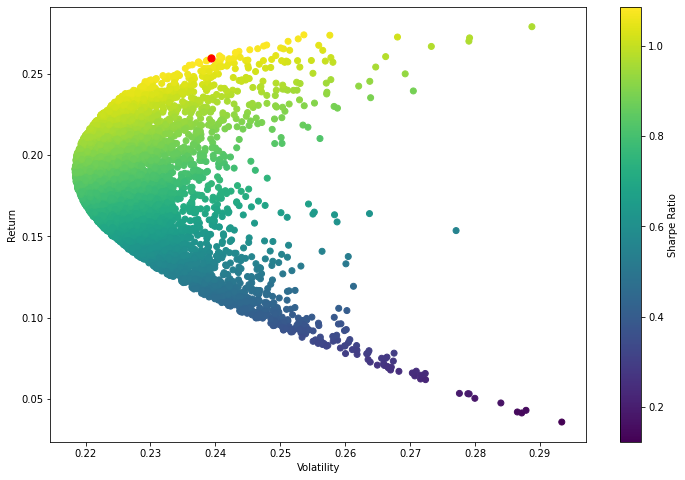

In [10]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50) # red dot
plt.show()

In [11]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
# the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

In [12]:
cons = ({'type': 'eq', 'fun': check_sum})
bounds = ((0,1), (0,1), (0,1), (0,1))
init_guess = [0.25, 0.25, 0.25, 0.25]

In [14]:
from scipy.optimize import minimize

opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
print(opt_results)

     fun: -1.0900889492220636
     jac: array([ 1.92657113e-04, -1.26317143e-04,  4.95019123e-01, -4.89890575e-04])
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.47891424, 0.44837372, 0.        , 0.07271204])


In [15]:
get_ret_vol_sr(opt_results.x)

array([0.26529064, 0.24336605, 1.09008895])

In [17]:
frontier_y = np.linspace(0, 0.35, 200) # return in plot doesn't go much higher than 0.35

In [18]:
def minimize_volatility(weights):
  return get_ret_vol_sr(weights)[1]

In [19]:
frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

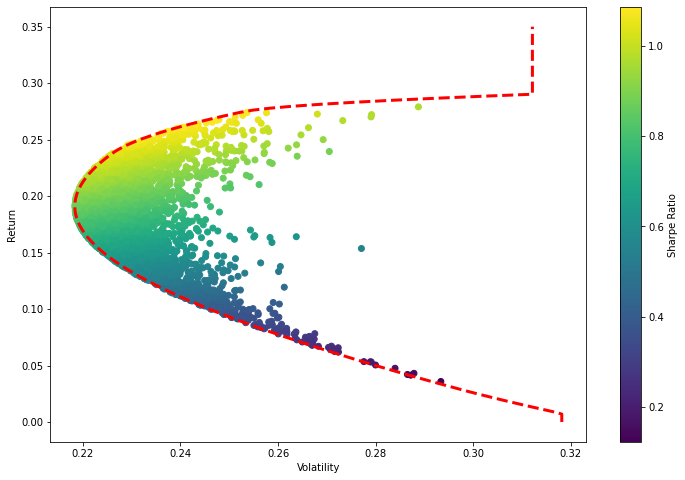

In [20]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x,frontier_y, 'r--', linewidth=3)
plt.savefig('cover.png')
plt.show()